In [2]:
from IPython import get_ipython


def type_of_script():
    """
    Detects and returns the type of python kernel
    :return: string 'jupyter' or 'ipython' or 'terminal'
    """
    try:
        ipy_str = str(type(get_ipython()))
        if 'zmqshell' in ipy_str:
            return 'jupyter'
        if 'terminal' in ipy_str:
            return 'ipython'
    except:
        return 'terminal'


if type_of_script() == 'jupyter':
    from tqdm.notebook import tqdm
else:
    from tqdm import tqdm
    
import matplotlib.pyplot as plt # type: module
import matplotlib.ticker as ticker
from matplotlib import colormaps
from matplotlib.colors import Normalize
import matplotlib.gridspec as gridspec

import numpy as np
import os, glob, atexit, signal
os.nice(19)
import time
import warnings

from rur.fortranfile import FortranFile
from rur import uri, uhmi, painter, drawer
from rur.sci.photometry import measure_luminosity
from rur.sci.geometry import get_angles, euler_angle
from rur.utool import rotate_data
from scipy.ndimage import gaussian_filter
uri.timer.verbose=0
# from rur.sci.kinematics import f_getpot

from icl_IO import mode2repo, pklsave, pklload
from icl_tool import *
from icl_numba import large_isin, large_isind, isin
from icl_draw import drawsnap, add_scalebar, addtext, MakeSub_nolabel, label_to_in, fancy_axis, circle
from importlib import reload
from copy import deepcopy
from multiprocessing import Pool, shared_memory, Value

In [3]:
mode1 = 'nh'
database1 = f"/home/jeon/MissingSat/database/{mode1}"
iout1 = 1026
repo1, rurmode1, dp1 = mode2repo(mode1)
snap1 = uri.RamsesSnapshot(repo1, iout1, mode=rurmode1)
snap1s = uri.TimeSeries(snap1)
snap1s.read_iout_avail()
nout1 = snap1s.iout_avail['iout']; nout=nout1[nout1 <= iout1]
gal1s = uhmi.HaloMaker.load(snap1, galaxy=True, double_precision=dp1)
hal1s = uhmi.HaloMaker.load(snap1, galaxy=False, double_precision=dp1)

mode2 = 'nh2'
database2 = f"/home/jeon/MissingSat/database/{mode2}"
iout2 = 797
repo2, rurmode2, dp2 = mode2repo(mode2)
snap2 = uri.RamsesSnapshot(repo2, iout2, mode=rurmode2)
snap2s = uri.TimeSeries(snap2)
snap2s.read_iout_avail()
nout2 = snap2s.iout_avail['iout']; nout=nout2[nout2 <= iout2]
gal2s = uhmi.HaloMaker.load(snap2, galaxy=True, double_precision=dp2)
hal2s = uhmi.HaloMaker.load(snap2, galaxy=False, double_precision=dp2)

from common_func import *

In [4]:
if(not os.path.exists(f"{database1}/LocalGroup.pickle")):
    LG1 = pklload(f"{database1}/LG.pickle")
    keys = list(LG1.keys())
    for key in keys:
        if(not LG1[key]['isLG']):
            del LG1[key]
    pklsave(LG1, f"{database1}/LocalGroup.pickle")
LG1 = pklload(f"{database1}/LocalGroup.pickle")

if(not os.path.exists(f"{database2}/LocalGroup.pickle")):
    LG2 = pklload(f"{database2}/LG.pickle")
    keys = list(LG2.keys())
    for key in keys:
        if(not LG2[key]['isLG']):
            del LG2[key]
    pklsave(LG2, f"{database2}/LocalGroup.pickle")
LG2 = pklload(f"{database2}/LocalGroup.pickle")

In [5]:
if(not os.path.exists(f"{database1}/main_prog/mainhalos.pickle")):
    mainhalos1 = {}
    for i in range(10):
        fname = f"{database1}/main_prog/mainhalos_{i}.pickle"
        tmp = pklload(fname)
        keys = list(tmp.keys())
        for key in keys:
            if(key in mainhalos1):
                mainhalos1[key] = np.hstack((mainhalos1[key], tmp[key]))
            else:
                mainhalos1[key] = tmp[key]
    for key in keys:
        argsort = np.argsort(-mainhalos1[key]['timestep'])
        mainhalos1[key] = mainhalos1[key][argsort]
    pklsave(mainhalos1, f"{database1}/main_prog/mainhalos.pickle")
mainhalos1 = pklload(f"{database1}/main_prog/mainhalos.pickle")

if(not os.path.exists(f"{database2}/main_prog/mainhalos.pickle")):
    mainhalos2 = {}
    for i in range(10):
        fname = f"{database2}/main_prog/mainhalos_{i}.pickle"
        tmp = pklload(fname)
        keys = list(tmp.keys())
        for key in keys:
            if(key in mainhalos2):
                mainhalos2[key] = np.hstack((mainhalos2[key], tmp[key]))
            else:
                mainhalos2[key] = tmp[key]
    for key in keys:
        argsort = np.argsort(-mainhalos2[key]['timestep'])
        mainhalos2[key] = mainhalos2[key][argsort]
    pklsave(mainhalos2, f"{database2}/main_prog/mainhalos.pickle")
mainhalos2 = pklload(f"{database2}/main_prog/mainhalos.pickle")

In [6]:
branch = mainhalos1[1]

In [7]:
print(branch.dtype)

[('nparts', '<i4'), ('id', '<i4'), ('timestep', '<i4'), ('level', '<i4'), ('host', '<i4'), ('hostsub', '<i4'), ('nbsub', '<i4'), ('nextsub', '<i4'), ('aexp', '<f8'), ('m', '<f8'), ('x', '<f8'), ('y', '<f8'), ('z', '<f8'), ('vx', '<f8'), ('vy', '<f8'), ('vz', '<f8'), ('Lx', '<f8'), ('Ly', '<f8'), ('Lz', '<f8'), ('r', '<f8'), ('a', '<f8'), ('b', '<f8'), ('c', '<f8'), ('ek', '<f8'), ('ep', '<f8'), ('et', '<f8'), ('spin', '<f8'), ('sigma', '<f8'), ('sigma_bulge', '<f8'), ('m_bulge', '<f8'), ('rvir', '<f8'), ('mvir', '<f8'), ('tvir', '<f8'), ('cvel', '<f8'), ('rho0', '<f8'), ('rc', '<f8'), ('halo_id', '<i4'), ('halo_nparts', '<i4'), ('halo_level', '<i4'), ('halo_host', '<i4'), ('halo_hostsub', '<i4'), ('halo_x', '<f8'), ('halo_y', '<f8'), ('halo_z', '<f8'), ('halo_vx', '<f8'), ('halo_vy', '<f8'), ('halo_vz', '<f8'), ('halo_mvir', '<f8'), ('halo_rvir', '<f8'), ('fcontam', '<f8'), ('dist', '<f8'), ('central', '?'), ('main', '?'), ('r200', '<f8'), ('m200', '<f8'), ('r200_code', '<f8'), ('m_sta

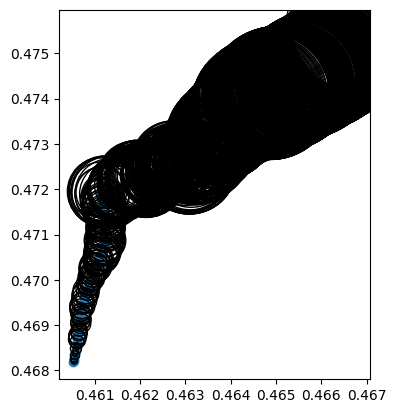

In [9]:
plt.scatter(branch['x'], branch['y'])
for ib in branch:
    cir = plt.Circle((ib['x'], ib['y']), ib['r200_code'], fill=False)
    plt.gca().add_artist(cir)
plt.gca().set_aspect('equal')